## Content:
- **[Part 1](#part1)- Importing the data set, packages used**
- **[Part 2](#part2)- Preprocessing Data**
- **[Part 3](#part3) -  Decision Trees**
- **[Part 4](#part4) -  Random Forest**
- **[Part 5](#part5) -  Naive Bayes**
- **[Part 6](#part6) - Gradient Boost Classifier**
- **[Part 7](#part6) - Cat Boost Classifier**
- **[Part 8](#part6) - XGB Boost Classifier**


[Back to top](#Content:)


<a id='part1'></a>

# Part 1 -  Importing the data set

In [11]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
%matplotlib inline

In [12]:
random.seed(0)

In [13]:
# Loading Dataset
df = pd.read_csv("healthcare/train_data.csv", na_values=['NA', '?'])

In [14]:
# Dropping na values for 
df = df.dropna()

In [15]:
# Dropping case_id
df.drop(['case_id'], axis=1, inplace=True)

[Back to top](#Content:)


<a id='part2'></a>

# Part 2 -  Preprocessing Data

### Hot encoded Data

In [16]:
# Function to hot encode the column with name : name for dataframe df
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True) 

In [17]:
from sklearn.preprocessing import LabelEncoder 
# Columns where we use Label Encoding
le_string_columns = ['Severity of Illness', 'Age' ]
# Columns where we use One Hot Encoding
dummies_string_columns = ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code',  'Type of Admission']
encoder = LabelEncoder()

## label_encoded data
Xe = df.drop(['Stay'], axis=1)
Xe['Severity of Illness']= Xe['Severity of Illness'].map({'Minor': 0,  'Moderate': 1,'Extreme': 2})
Xe['Age'] = encoder.fit_transform(Xe['Age'])

ye = df['Stay']
ye = encoder.fit_transform(ye)

for column in dummies_string_columns :
    encode_text_dummy(Xe, column)
    

### Scaling and Splitting Data 

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X = Xe.values
y = ye
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
for i in range(X_train.shape[1]) :
    X_train[:,i]= scaler.fit_transform(X_train[:,i].reshape(-1, 1))[:,0]
    X_test[:,i] = scaler.transform(X_test[:,i].reshape(-1, 1))[:,0]

### Scoring

In [19]:
K = 10 # Num of Classes 
# Classes can be ranked here from 0-10
def score(pred, target):
    error = (np.mean(np.abs(pred-target)))/K
    score = 1 - error
    return score

# Models

We start by base models, models used here are that are most adapted to the nature of the problem :
- Decision Tree
- Random Forest
- Naive Bayes
- XGBoost

In [20]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

[Back to top](#Content:)


<a id='part3'></a>

# Part 3 -  Decision Trees

In [26]:
from sklearn.tree import DecisionTreeClassifier
# Instantiating and fitting the data
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy')

In [27]:
y_pred = tree.predict(X_test)

acc = accuracy_score(y_test, y_pred)
score = score(y_test, y_pred)

print('Accuracy : %.3f' % acc)
print('Score : %.3f' % score)

Accuracy : 0.300
Score : 0.851


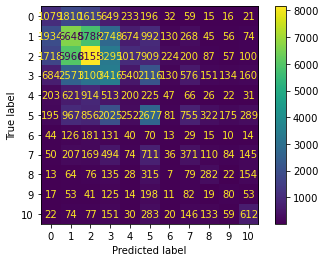

In [28]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

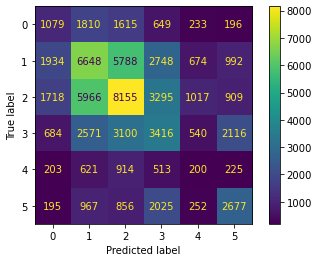

In [29]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

Decision Trees appear to give reasonnable results. We still have lot of confusion especially between close categories.

## Decision tree with gini criterion

In [30]:
# Instantiating and fitting the data
tree = DecisionTreeClassifier(criterion='gini')
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [32]:
y_pred = tree.predict(X_test)

acc = accuracy_score(y_test, y_pred)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K

print('Accuracy : %.3f' % acc)
print('Score : %.3f' % score)

Accuracy : 0.300
Score : 0.851


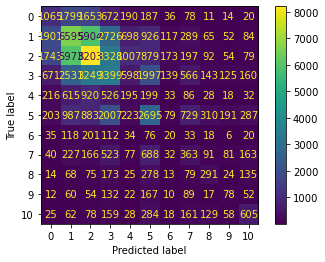

In [33]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

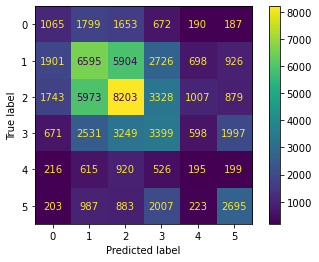

In [34]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

We get same result, Dataset is large enough to avoid using cross validation but we give it a try anyways

In [37]:
kf = KFold(5, shuffle=True)
tree = DecisionTreeClassifier(criterion='entropy')
fold = 0 
for train_index, validate_index in kf.split(X,y):
    tree.fit(X[train_index], y[train_index])
    y_test_v = y[validate_index]
    y_pred = tree.predict(X[validate_index])
    score = 1 - (np.mean(np.abs(y_pred-y_test_v)))/K
    fold += 1
    print(f'Results after fold {fold}')
    print(f'Accuracy : %.4f' % accuracy_score(y_test_v, y_pred))
    print(f'Score : %.4f' % score)
    print('---------------------')

Results after fold 1
Accuracy : 0.2992
Score : 0.8505
---------------------
Results after fold 2
Accuracy : 0.2998
Score : 0.8506
---------------------
Results after fold 3
Accuracy : 0.2988
Score : 0.8514
---------------------
Results after fold 4
Accuracy : 0.3001
Score : 0.8509
---------------------
Results after fold 5
Accuracy : 0.2973
Score : 0.8503
---------------------


Results are consisting, now let's move to other algorithms and see if we can improve

[Back to top](#Content:)


<a id='part4'></a>

# Part 4 -  Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
# Instantiating and fitting the data
forest = RandomForestClassifier(n_estimators=10, criterion='entropy')
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

Accuracy : 0.365
Score : 0.8774


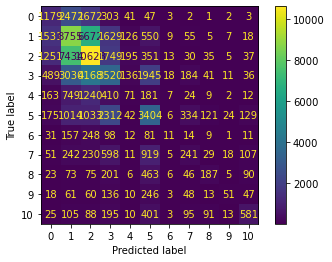

In [45]:
y_pred = forest.predict(X_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
print(f'Score : %.4f' % score)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

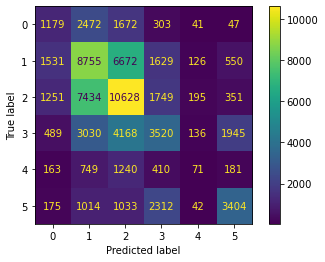

In [46]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

Both accuracy and score are better, we are going to try with different n_estimators

In [48]:
accuracy_data = []
score_data = []

for i in range(20,70,4):
    forest = RandomForestClassifier(n_estimators=i, criterion='entropy')
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    score = 1-np.mean(np.abs(y_test-y_pred))/K
    print(f'n_estimators : {i}')
    print(f'Accuracy : %.4f' % accuracy)
    print(f'Score  : %.4f' % score)
    print('--------------')
    accuracy_data.append(accuracy)
    score_data.append(score)
    
    

n_estimators : 20
Accuracy : 0.3808
Score  : 0.8832
--------------
n_estimators : 24
Accuracy : 0.3847
Score  : 0.8843
--------------
n_estimators : 28
Accuracy : 0.3849
Score  : 0.8844
--------------
n_estimators : 32
Accuracy : 0.3908
Score  : 0.8860
--------------
n_estimators : 36
Accuracy : 0.3892
Score  : 0.8857
--------------
n_estimators : 40
Accuracy : 0.3911
Score  : 0.8863
--------------
n_estimators : 44
Accuracy : 0.3919
Score  : 0.8864
--------------
n_estimators : 48
Accuracy : 0.3932
Score  : 0.8866
--------------
n_estimators : 52
Accuracy : 0.3927
Score  : 0.8871
--------------
n_estimators : 56
Accuracy : 0.3964
Score  : 0.8877
--------------
n_estimators : 60
Accuracy : 0.3951
Score  : 0.8875
--------------
n_estimators : 64
Accuracy : 0.3959
Score  : 0.8879
--------------
n_estimators : 68
Accuracy : 0.3953
Score  : 0.8875
--------------


## Plotting accuracy and score with increasing n_estimators

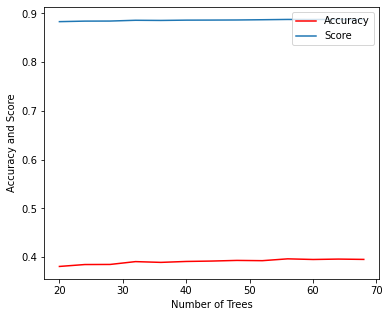

In [49]:
nums = []
for i in range(20,70,4):
    nums.append(i)

fig = plt.figure(figsize=(6,5))
plt.plot(nums, accuracy_data, c='r', label='Accuracy')
plt.plot(nums, score_data, label='Score')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy and Score')
plt.legend(loc='upper right')
plt.show()
    

Looks like we reached the maximum of accuracy/score at around n_estimators = 60, we will keep this one and move forward

## Random Forest n_estimators = 60



In [50]:
# Instantiating and fitting the data
forest = RandomForestClassifier(n_estimators=60, criterion='entropy')
forest.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=60)

Accuracy : 0.396
Score : 0.8879


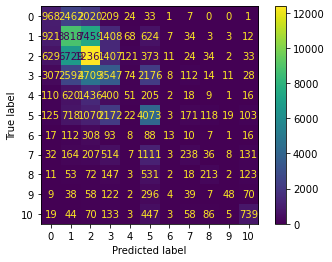

In [51]:
y_pred = forest.predict(X_test)
score = 1 - (np.mean(np.abs(y_pred-y_test)))/K
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
print(f'Score : %.4f' % score)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

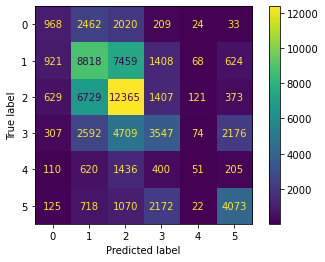

In [52]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

## Plotting Histograms to compare 

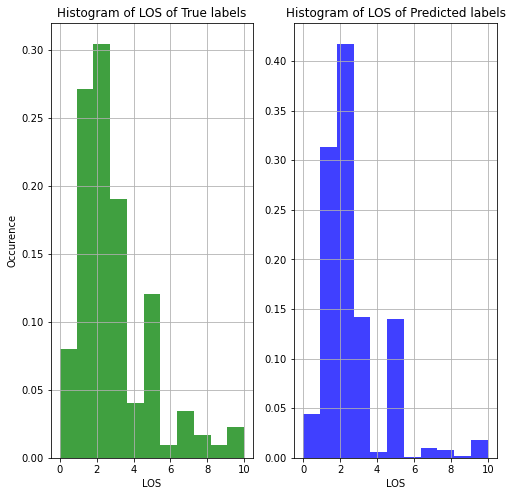

In [59]:
labels = np.unique(df['Stay'])
labels[-1] = '100+'

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(8, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11, label=labels, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11, label=labels, density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

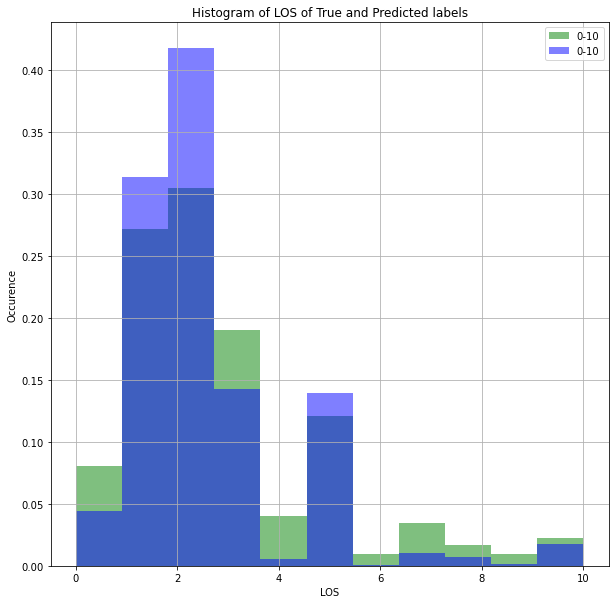

In [67]:
labels = np.unique(df['Stay'])
labels[-1] = '100+'

plt.figure(figsize = (10,10))

plt.hist(y_test, bins=11, label=labels, density=True, facecolor='g', alpha=0.5)
plt.hist(y_pred, bins=11, label=labels, density=True, facecolor='b', alpha=0.5)
plt.title('Histogram of LOS of True and Predicted labels')
plt.xlabel('LOS')
plt.ylabel('Occurence')
plt.legend()
plt.grid(True)



plt.show()

The model reproduce the distribution of the data well enough, but we can see that it predicts categories 1 and 2, more than it should while predicting categories 0 and 3 less. It also neglects categories 6, 7 ...10.


[Back to top](#Content:)


<a id='part5'></a>

# Part 5 -  Naive Bayes

## Base Model for Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB(var_smoothing=1)
model.fit(X_train, y_train)


GaussianNB(var_smoothing=1)

Accuracy : 0.329
Score : 0.8590


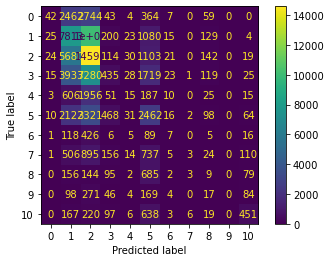

In [22]:
y_pred = model.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
score = 1-np.mean(np.abs(y_test-y_pred))/K
print(f'Score : %.4f' % score)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

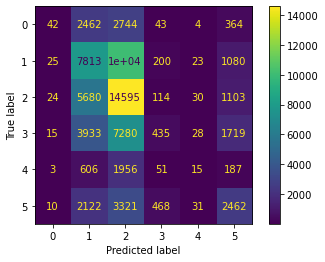

In [23]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

## Testing different smoothing values 

In [24]:
smoothing = [1e-3, 1e-2, 1e-1, 1, 10]

for var_smoothing in smoothing :
    model = GaussianNB(var_smoothing=var_smoothing)
    model.fit(X_test, y_test)
    y_pred = model.predict(X_test)
    print(f'Smoothing parameter : {var_smoothing}')
    print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
    score = 1-np.mean(np.abs(y_test-y_pred))/K
    print(f'Score : %.4f' % score)
    print('----------------------')
    

Smoothing parameter : 0.001
Accuracy : 0.155
Score : 0.7697
----------------------
Smoothing parameter : 0.01
Accuracy : 0.213
Score : 0.7960
----------------------
Smoothing parameter : 0.1
Accuracy : 0.267
Score : 0.8266
----------------------
Smoothing parameter : 1
Accuracy : 0.314
Score : 0.8540
----------------------
Smoothing parameter : 10
Accuracy : 0.278
Score : 0.8528
----------------------


We can see that we get best results when the smoothing parameter is in the order of 1, let try different values to see if we can get something different

In [25]:
smoothing = [0.5, 1, 2, 3, 5]

for var_smoothing in smoothing :
    model = GaussianNB(var_smoothing=var_smoothing)
    model.fit(X_test, y_test)
    y_pred = model.predict(X_test)
    print(f'Smoothing parameter : {var_smoothing}')
    print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
    score = 1-np.mean(np.abs(y_test-y_pred))/K
    print(f'Score : %.4f' % score)
    print('----------------------')
    

Smoothing parameter : 0.5
Accuracy : 0.308
Score : 0.8502
----------------------
Smoothing parameter : 1
Accuracy : 0.314
Score : 0.8540
----------------------
Smoothing parameter : 2
Accuracy : 0.303
Score : 0.8494
----------------------
Smoothing parameter : 3
Accuracy : 0.302
Score : 0.8517
----------------------
Smoothing parameter : 5
Accuracy : 0.292
Score : 0.8529
----------------------


It seems like our base model might be the best choice when choosing Naive Bayes, let's see how the histogram looks like

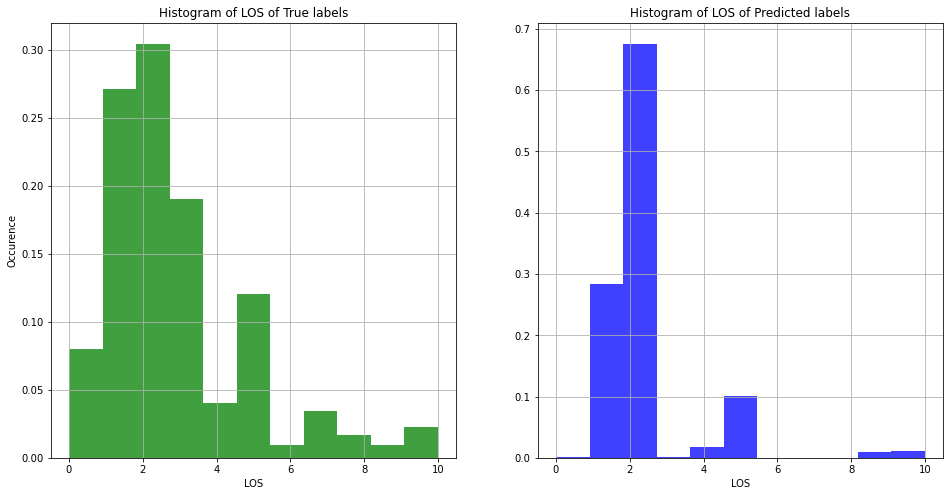

In [27]:

model = GaussianNB(var_smoothing=1)
model.fit(X_test, y_test)
y_pred = model.predict(X_test)

labels = np.unique(df['Stay'])
labels[-1] = '100+'

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11, label=labels, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11, label=labels, density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

Naive Bayes fails to capture the shape of the distribution and seems to be overfitting by assigning lot of samples to categories 2

We try different models not seen in the course that are more powerful to see if we can have better results and compare

[Back to top](#Content:)


<a id='part6'></a>

# Part 6 -  Gradient Boost Classifier

In [79]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

GradientBoostingClassifier()

Accuracy : 0.415
Score : 0.8920


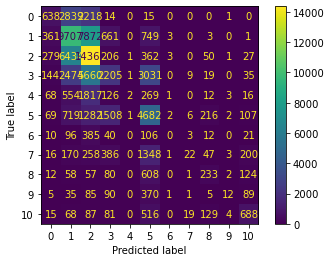

In [80]:
y_pred = model.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
score = 1-np.mean(np.abs(y_test-y_pred))/K
print(f'Score : %.4f' % score)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

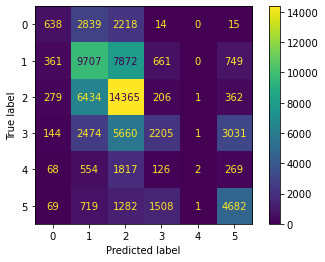

In [81]:
cm_reduced = cm[:6,:6]

cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

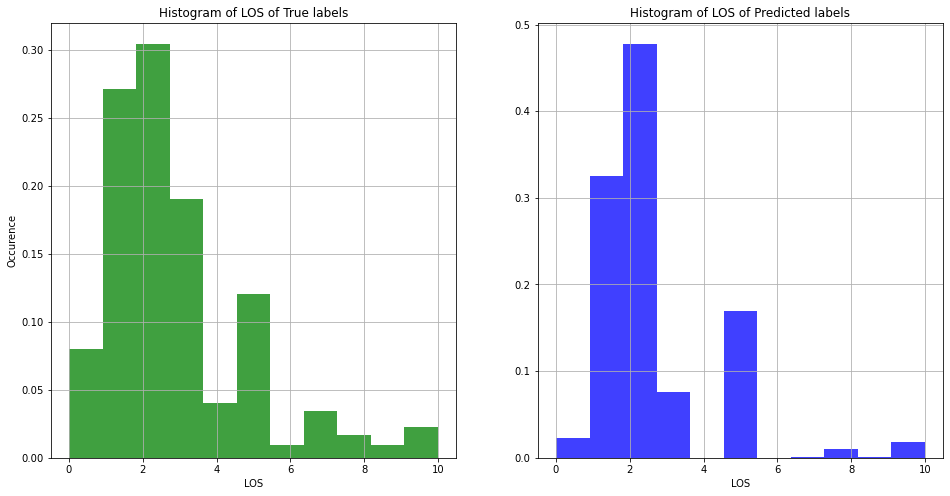

In [82]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11, label=labels, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11, label=labels, density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

The best result we got for Random Forest was : Accuracy : 0.396 , Score : 0.8879

Gradient Boost results are better : Accuracy : 0.415, Score : 0.8920

Nevertheless it stills suffers from the same problem as Random Forest as it fails to capture the distribution of data and overfits by predicting category 2 too often.




[Back to top](#Content:)


<a id='part7'></a>

# Part 7 -  Cat Boost Classifier

In [11]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(iterations=1000)
cb.fit(X_train, y_train)

Learning rate set to 0.104539
0:	learn: 2.2234084	total: 192ms	remaining: 3m 11s
1:	learn: 2.1063143	total: 308ms	remaining: 2m 33s
2:	learn: 2.0204817	total: 418ms	remaining: 2m 18s
3:	learn: 1.9529196	total: 527ms	remaining: 2m 11s
4:	learn: 1.8960600	total: 641ms	remaining: 2m 7s
5:	learn: 1.8534948	total: 752ms	remaining: 2m 4s
6:	learn: 1.8154044	total: 857ms	remaining: 2m 1s
7:	learn: 1.7823440	total: 981ms	remaining: 2m 1s
8:	learn: 1.7539753	total: 1.09s	remaining: 2m
9:	learn: 1.7296449	total: 1.21s	remaining: 1m 59s
10:	learn: 1.7097871	total: 1.32s	remaining: 1m 59s
11:	learn: 1.6934331	total: 1.44s	remaining: 1m 58s
12:	learn: 1.6766603	total: 1.56s	remaining: 1m 58s
13:	learn: 1.6634513	total: 1.66s	remaining: 1m 57s
14:	learn: 1.6512975	total: 1.77s	remaining: 1m 56s
15:	learn: 1.6413284	total: 1.88s	remaining: 1m 55s
16:	learn: 1.6319781	total: 2.01s	remaining: 1m 56s
17:	learn: 1.6237897	total: 2.13s	remaining: 1m 56s
18:	learn: 1.6165654	total: 2.23s	remaining: 1m 55s


158:	learn: 1.4981273	total: 19.3s	remaining: 1m 42s
159:	learn: 1.4978334	total: 19.5s	remaining: 1m 42s
160:	learn: 1.4976460	total: 19.6s	remaining: 1m 41s
161:	learn: 1.4973133	total: 19.7s	remaining: 1m 41s
162:	learn: 1.4970757	total: 19.8s	remaining: 1m 41s
163:	learn: 1.4967462	total: 19.9s	remaining: 1m 41s
164:	learn: 1.4964247	total: 20s	remaining: 1m 41s
165:	learn: 1.4960755	total: 20.2s	remaining: 1m 41s
166:	learn: 1.4956311	total: 20.3s	remaining: 1m 41s
167:	learn: 1.4955089	total: 20.4s	remaining: 1m 41s
168:	learn: 1.4953423	total: 20.5s	remaining: 1m 41s
169:	learn: 1.4952161	total: 20.7s	remaining: 1m 40s
170:	learn: 1.4949714	total: 20.8s	remaining: 1m 40s
171:	learn: 1.4947408	total: 20.9s	remaining: 1m 40s
172:	learn: 1.4946092	total: 21s	remaining: 1m 40s
173:	learn: 1.4942393	total: 21.2s	remaining: 1m 40s
174:	learn: 1.4939958	total: 21.3s	remaining: 1m 40s
175:	learn: 1.4938066	total: 21.4s	remaining: 1m 40s
176:	learn: 1.4937119	total: 21.6s	remaining: 1m 4

314:	learn: 1.4687723	total: 38.6s	remaining: 1m 24s
315:	learn: 1.4686123	total: 38.8s	remaining: 1m 23s
316:	learn: 1.4684246	total: 38.9s	remaining: 1m 23s
317:	learn: 1.4682781	total: 39s	remaining: 1m 23s
318:	learn: 1.4681743	total: 39.1s	remaining: 1m 23s
319:	learn: 1.4680995	total: 39.3s	remaining: 1m 23s
320:	learn: 1.4678398	total: 39.4s	remaining: 1m 23s
321:	learn: 1.4677408	total: 39.5s	remaining: 1m 23s
322:	learn: 1.4675026	total: 39.6s	remaining: 1m 23s
323:	learn: 1.4673376	total: 39.7s	remaining: 1m 22s
324:	learn: 1.4672795	total: 39.9s	remaining: 1m 22s
325:	learn: 1.4671274	total: 40s	remaining: 1m 22s
326:	learn: 1.4670001	total: 40.1s	remaining: 1m 22s
327:	learn: 1.4668119	total: 40.2s	remaining: 1m 22s
328:	learn: 1.4666522	total: 40.4s	remaining: 1m 22s
329:	learn: 1.4665015	total: 40.5s	remaining: 1m 22s
330:	learn: 1.4663806	total: 40.6s	remaining: 1m 22s
331:	learn: 1.4662963	total: 40.7s	remaining: 1m 21s
332:	learn: 1.4662053	total: 40.9s	remaining: 1m 2

470:	learn: 1.4495482	total: 58.9s	remaining: 1m 6s
471:	learn: 1.4494089	total: 59s	remaining: 1m 6s
472:	learn: 1.4493045	total: 59.2s	remaining: 1m 5s
473:	learn: 1.4492037	total: 59.3s	remaining: 1m 5s
474:	learn: 1.4490654	total: 59.4s	remaining: 1m 5s
475:	learn: 1.4489050	total: 59.6s	remaining: 1m 5s
476:	learn: 1.4487845	total: 59.7s	remaining: 1m 5s
477:	learn: 1.4486739	total: 59.8s	remaining: 1m 5s
478:	learn: 1.4485712	total: 60s	remaining: 1m 5s
479:	learn: 1.4485391	total: 1m	remaining: 1m 5s
480:	learn: 1.4483253	total: 1m	remaining: 1m 4s
481:	learn: 1.4481676	total: 1m	remaining: 1m 4s
482:	learn: 1.4480083	total: 1m	remaining: 1m 4s
483:	learn: 1.4478381	total: 1m	remaining: 1m 4s
484:	learn: 1.4476616	total: 1m	remaining: 1m 4s
485:	learn: 1.4474920	total: 1m	remaining: 1m 4s
486:	learn: 1.4474105	total: 1m	remaining: 1m 4s
487:	learn: 1.4472871	total: 1m 1s	remaining: 1m 4s
488:	learn: 1.4471285	total: 1m 1s	remaining: 1m 4s
489:	learn: 1.4469931	total: 1m 1s	remai

628:	learn: 1.4304326	total: 1m 19s	remaining: 47.1s
629:	learn: 1.4303427	total: 1m 19s	remaining: 46.9s
630:	learn: 1.4302715	total: 1m 20s	remaining: 46.8s
631:	learn: 1.4301351	total: 1m 20s	remaining: 46.7s
632:	learn: 1.4300116	total: 1m 20s	remaining: 46.6s
633:	learn: 1.4299130	total: 1m 20s	remaining: 46.5s
634:	learn: 1.4298307	total: 1m 20s	remaining: 46.3s
635:	learn: 1.4297055	total: 1m 20s	remaining: 46.2s
636:	learn: 1.4295844	total: 1m 20s	remaining: 46.1s
637:	learn: 1.4294835	total: 1m 20s	remaining: 46s
638:	learn: 1.4293525	total: 1m 21s	remaining: 45.8s
639:	learn: 1.4293165	total: 1m 21s	remaining: 45.7s
640:	learn: 1.4292512	total: 1m 21s	remaining: 45.6s
641:	learn: 1.4291147	total: 1m 21s	remaining: 45.5s
642:	learn: 1.4289995	total: 1m 21s	remaining: 45.3s
643:	learn: 1.4288545	total: 1m 21s	remaining: 45.2s
644:	learn: 1.4287298	total: 1m 21s	remaining: 45.1s
645:	learn: 1.4286066	total: 1m 22s	remaining: 45s
646:	learn: 1.4284938	total: 1m 22s	remaining: 44.

784:	learn: 1.4132750	total: 1m 40s	remaining: 27.6s
785:	learn: 1.4131851	total: 1m 40s	remaining: 27.4s
786:	learn: 1.4130885	total: 1m 40s	remaining: 27.3s
787:	learn: 1.4129432	total: 1m 41s	remaining: 27.2s
788:	learn: 1.4128204	total: 1m 41s	remaining: 27s
789:	learn: 1.4127046	total: 1m 41s	remaining: 26.9s
790:	learn: 1.4126016	total: 1m 41s	remaining: 26.8s
791:	learn: 1.4124461	total: 1m 41s	remaining: 26.7s
792:	learn: 1.4123710	total: 1m 41s	remaining: 26.6s
793:	learn: 1.4122581	total: 1m 41s	remaining: 26.4s
794:	learn: 1.4121805	total: 1m 42s	remaining: 26.3s
795:	learn: 1.4121034	total: 1m 42s	remaining: 26.2s
796:	learn: 1.4120773	total: 1m 42s	remaining: 26.1s
797:	learn: 1.4119399	total: 1m 42s	remaining: 25.9s
798:	learn: 1.4118940	total: 1m 42s	remaining: 25.8s
799:	learn: 1.4117973	total: 1m 42s	remaining: 25.7s
800:	learn: 1.4116836	total: 1m 42s	remaining: 25.6s
801:	learn: 1.4115734	total: 1m 43s	remaining: 25.4s
802:	learn: 1.4114849	total: 1m 43s	remaining: 2

940:	learn: 1.3972646	total: 2m 2s	remaining: 7.71s
941:	learn: 1.3971305	total: 2m 3s	remaining: 7.58s
942:	learn: 1.3970230	total: 2m 3s	remaining: 7.45s
943:	learn: 1.3969753	total: 2m 3s	remaining: 7.32s
944:	learn: 1.3968521	total: 2m 3s	remaining: 7.18s
945:	learn: 1.3967529	total: 2m 3s	remaining: 7.05s
946:	learn: 1.3967087	total: 2m 3s	remaining: 6.93s
947:	learn: 1.3965909	total: 2m 3s	remaining: 6.8s
948:	learn: 1.3964950	total: 2m 4s	remaining: 6.67s
949:	learn: 1.3964023	total: 2m 4s	remaining: 6.54s
950:	learn: 1.3963139	total: 2m 4s	remaining: 6.41s
951:	learn: 1.3962111	total: 2m 4s	remaining: 6.28s
952:	learn: 1.3961189	total: 2m 4s	remaining: 6.15s
953:	learn: 1.3960041	total: 2m 4s	remaining: 6.02s
954:	learn: 1.3959004	total: 2m 4s	remaining: 5.89s
955:	learn: 1.3958242	total: 2m 5s	remaining: 5.76s
956:	learn: 1.3957009	total: 2m 5s	remaining: 5.63s
957:	learn: 1.3955931	total: 2m 5s	remaining: 5.5s
958:	learn: 1.3954907	total: 2m 5s	remaining: 5.37s
959:	learn: 1.

In [12]:
y_pred = cb.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))


Accuracy : 0.428


There appears to have problems when calculating score directly so we used the step by step method

In [13]:
y_pred = y_pred.flatten()

In [14]:
error = np.abs(y_test-y_pred)

In [15]:
mean_error = np.mean(error)

In [17]:
K = 10
score = 1-mean_error/K

In [18]:
print(f'Score : %.4f' % score)

Score : 0.8950


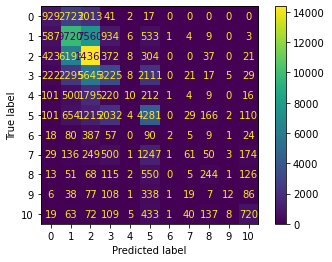

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

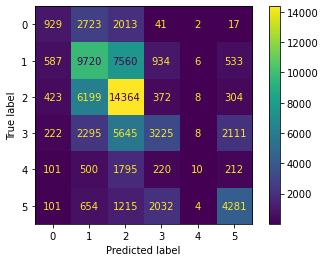

In [20]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

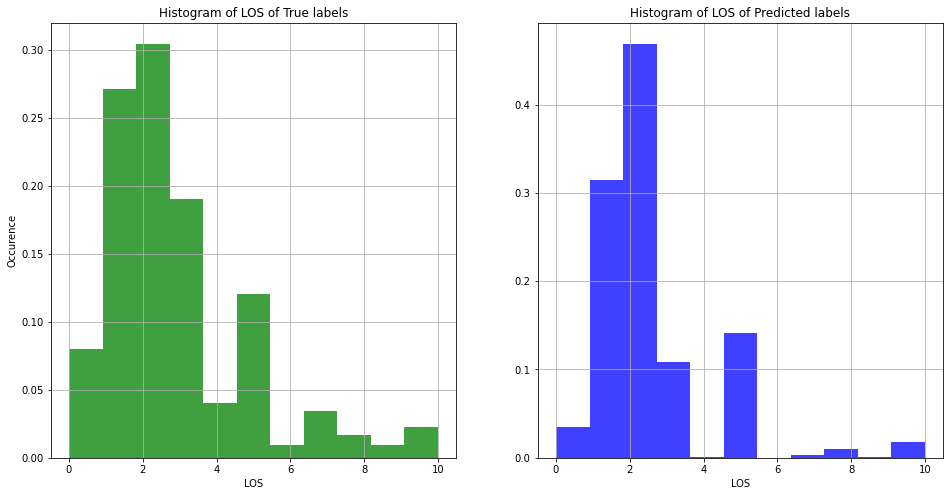

In [22]:
labels = np.unique(df['Stay'])
labels[-1] = '100+'
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11, label=labels, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11, label=labels, density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

The best result we got for Random Forest was : Accuracy : 0.396 , Score : 0.8879

Gradient Boost results :                       Accuracy : 0.415 , Score : 0.8920

CatBoost results :                             Accuracy : 0.428 , Score : 0.895


These results are slightly better but again we have the same problem as before.




[Back to top](#Content:)


<a id='part8'></a>

# Part 8 -  XGB Boost Classifier

In [23]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

/Users/baraa/opt/anaconda3/envs/tf/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Accuracy : 0.426
Score : 0.8944


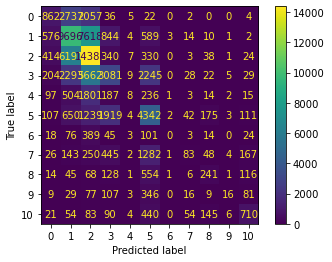

In [24]:
y_pred = xgb.predict(X_test)
print(f'Accuracy : %.3f' % accuracy_score(y_test, y_pred))
score = 1-np.mean(np.abs(y_test-y_pred))/K
print(f'Score : %.4f' % score)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

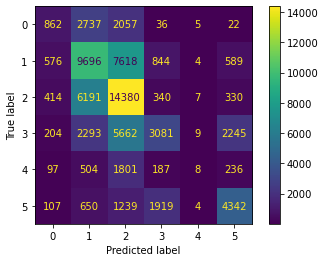

In [25]:
cm_reduced = cm[:6,:6]
cm = confusion_matrix(y_test, y_pred);
disp = ConfusionMatrixDisplay(cm_reduced)
disp.plot();

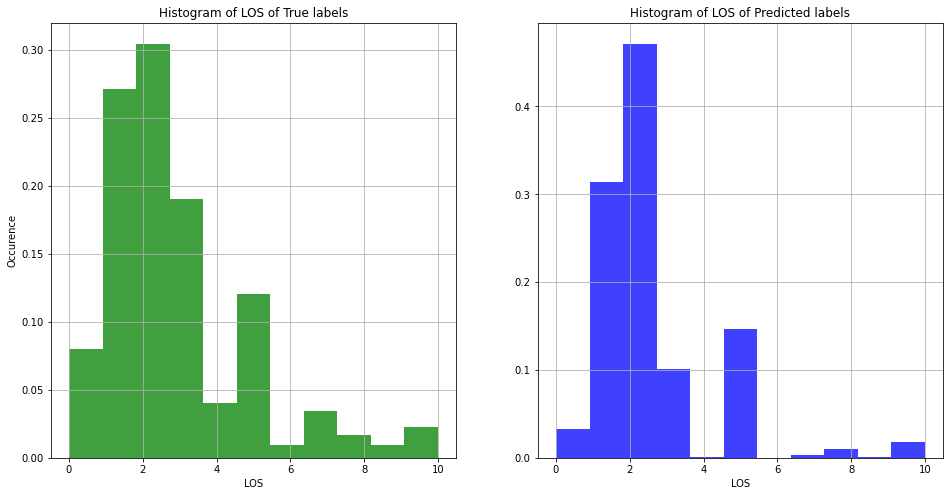

In [26]:

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)
ax1.grid(True)
ax1.hist(y_test, bins=11, label=labels, density=True, facecolor='g', alpha=0.75)
ax1.set_title('Histogram of LOS of True labels')
ax1.set_xlabel('LOS')
ax1.set_ylabel('Occurence')

ax2.grid(True)
ax2.hist(y_pred, bins=11, label=labels, density=True, facecolor='b', alpha=0.75)
ax2.set_title('Histogram of LOS of Predicted labels')
ax2.set_xlabel('LOS')



plt.show()

XGB Boost offers similar results to CatBoost, with the same issues

# Conclusion

We Have tried different models with different paramaters on the dataset, the results so far are not bad since most confusion happens between categories that are very close. In fact in our problem we have categories that are very close to each other which adds a layer of difficulty to the problem if we want to use accuracy as a metric. On the other hand the score method that measures how wrong the predictions are by taking into account the distance between categories gives descent results. We are now going to try classification with ANN and regression as well.